# Exploration of the SWaT dataset

###  Where does this data come from:
1. I went [here](https://itrust.sutd.edu.sg/itrust-labs_datasets/) and requested the WADI and SWaT datasets. 
2. I only downloaded the 2015 folder from the Google drive folder they granted me access to. This gave me lots of zip files though.
3. I copied the zip files, ran something like:

```sh
mkdir all
for x in *.zip ; do unzip -d all -o -u $x ; done
```
4. Since the "Network" folder was huge I decided to include the tables in the "Physical" folder only for now.


In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import diag_vae.constants as const
# from pandas_profiling import ProfileReport
from datetime import datetime
import matplotlib.pyplot as plt
from ipywidgets import interact
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## Read the data

In [3]:
# reading the time series data files (physics only!)
raw_file_paths = [const.SWAT_RAW_NORMAL_V0_PATH, const.SWAT_RAW_NORMAL_V1_PATH, const.SWAT_RAW_ATTACK_V0_PATH]
proc_file_paths = [const.SWAT_PARQUET_NORMAL_V0_PATH, const.SWAT_PARQUET_NORMAL_V1_PATH, const.SWAT_PARQUET_ATTACK_V0_PATH]



In [4]:
for raw_file_path, proc_file_path in zip(raw_file_paths, proc_file_paths):
   if not os.path.exists(proc_file_path):
      df =15
      df.to_parquet(proc_file_path)

In [5]:
df_normal_v0, df_normal_v1, df_attack_v0 = [pd.read_parquet(path) for path in proc_file_paths]

# read labels file
df_label = pd.read_excel(const.SWAT_RAW_LABEL_PATH)

## Check heads and basic stats

In [6]:
df_attack_v0.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal


In [7]:
df_normal_v1.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:30:00 PM,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
1,22/12/2015 4:30:01 PM,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2,22/12/2015 4:30:02 PM,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
3,22/12/2015 4:30:03 PM,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
4,22/12/2015 4:30:04 PM,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.0,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal


In [8]:
df_attack_v0.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal


## Symbols MAP

![SWAT Comps](../figures/SWAT_Components.png)

In [9]:
df_normal_v1.columns

Index([' Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201',
       'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204',
       'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401',
       'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502',
       'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501',
       'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603',
       'Normal/Attack'],
      dtype='object')

In [10]:
{f'Comp_{i}':[c for c in df_normal_v1.columns if f'{i}0' in c] for i in range(1,7)}

{'Comp_1': ['FIT101', 'LIT101', 'MV101', 'P101', 'P102'],
 'Comp_2': ['AIT201',
  'AIT202',
  'AIT203',
  'FIT201',
  'MV201',
  'P201',
  'P202',
  'P203',
  'P204',
  'P205',
  'P206'],
 'Comp_3': ['DPIT301',
  'FIT301',
  'LIT301',
  'MV301',
  'MV302',
  'MV303',
  'MV304',
  'P301',
  'P302'],
 'Comp_4': ['AIT401',
  'AIT402',
  'FIT401',
  'LIT401',
  'P401',
  'P402',
  'P403',
  'P404',
  'UV401'],
 'Comp_5': ['AIT501',
  'AIT502',
  'AIT503',
  'AIT504',
  'FIT501',
  'FIT502',
  'FIT503',
  'FIT504',
  'P501',
  'P502',
  'PIT501',
  'PIT502',
  'PIT503'],
 'Comp_6': ['FIT601', 'P601', 'P602', 'P603']}

In [11]:
df_normal_v0['Normal/Attack'].unique()

array(['Normal'], dtype=object)

In [12]:
df_label

,Attack #,Start Time,End Time,Attack Point,Start State,Attack,Actual Change,Expected Impact or attacker intent,Unexpected Outcome
0,1,2015-12-28 10:29:14,10:44:53,MV-101,MV-101 is closed,Open MV-101,Yes,Tank overflow,NaN
1,2,2015-12-28 10:51:08,10:58:30,P-102,P-101 is on where as P-102 is off,Turn on P-102,Yes,Pipe bursts,NaN
2,3,2015-12-28 11:22:00,11:28:22,LIT-101,Water level between L and H,Increase by 1 mm every second,No,Tank Underflow; Damage P-101,NaN
3,4,2015-12-28 11:47:39,11:54:08,MV-504,MV-504 is closed,Open MV-504,Yes,Halt RO shut down sequence; Reduce life of RO,No impact
4,5,2015-12-28 11:58:20,NaN,No Physical Impact Attack,NaN,NaN,NaN,NaN,NaN
5,6,2015-12-28 12:00:55,12:04:10,AIT-202,Value of AIT-202 is >7.05,Set value of AIT-202 as 6,No,P-203 turns off; Change in water quality,Impact seen on AIT-504 after two hours at arou...
6,7,2015-12-28 12:08:25,12:15:33,LIT-301,Water level between L and H,Water level increased above HH,No,Stop of inflow; Tank underflow; Damage P-301,NaN
7,8,2015-12-28 13:10:10,13:26:13,DPIT-301,Value of DPIT is <40kpa,Set value of DPIT as >40kpa,No,Backwash process is started again and again; N...,NaN
8,9,2015-12-28 14:15:00,NaN,No Physical Impact Attack,NaN,NaN,NaN,NaN,NaN
9,10,2015-12-28 14:16:20,14:19:00,FIT-401,Value of FIT-401 above 1,Set value of FIT-401 as <0.7,No,UV shutdown; P-501 turns off;,UV did not shutdown; P-501 did not turn off


## What is the difference between those two files?

In [14]:
# Timeframe? Takes a minute or two
for ind, df in enumerate([df_normal_v0, df_normal_v1]):
    print(f'Start timestamp v{ind}: {pd.to_datetime(df[" Timestamp"]).min()}')
    print(f'End timestamp v{ind}: {pd.to_datetime(df[" Timestamp"]).max()}')


KeyboardInterrupt



--> v1 seams to start half an hour later. I read somewhere that that is on purpose
but can't find where anymore. 

In [15]:
# Same schema in v0 and v1?
all(df_normal_v0.columns == df_normal_v1.columns)

True

--> Let's stick to v1, they'll have a reason for the
version bump anyways.

In [16]:
# Same schema in v1 and attack?
all(df_normal_v0.columns == df_attack_v0.columns)

False

In [17]:
set(df_attack_v0.columns).difference(set(df_normal_v1.columns))

{' AIT201', ' MV101', ' MV201', ' MV303', ' P201', ' P202', ' P204'}

Haha, they messed up the column names... I'll fix that later!

## Frequency?

In [18]:
pd.to_datetime(df_normal_v0[' Timestamp']).diff()[1:].unique()

KeyboardInterrupt: 

Ok, seems to be one seconds between all the timestamps

## Basic stats

In [ ]:
df_normal_v0.info()

No missing values, nice!

In [ ]:
# profile = ProfileReport(df_normal_v0,
#                         minimal=True, title='Pandas Profiling Report',
#                         explorative=True)
# profile.to_widgets()

## Check the label table

In [23]:
# check label dataset
df_label

,Attack #,Start Time,End Time,Attack Point,Start State,Attack,Actual Change,Expected Impact or attacker intent,Unexpected Outcome
0,1,2015-12-28 10:29:14,10:44:53,MV-101,MV-101 is closed,Open MV-101,Yes,Tank overflow,NaN
1,2,2015-12-28 10:51:08,10:58:30,P-102,P-101 is on where as P-102 is off,Turn on P-102,Yes,Pipe bursts,NaN
2,3,2015-12-28 11:22:00,11:28:22,LIT-101,Water level between L and H,Increase by 1 mm every second,No,Tank Underflow; Damage P-101,NaN
3,4,2015-12-28 11:47:39,11:54:08,MV-504,MV-504 is closed,Open MV-504,Yes,Halt RO shut down sequence; Reduce life of RO,No impact
4,5,2015-12-28 11:58:20,NaN,No Physical Impact Attack,NaN,NaN,NaN,NaN,NaN
5,6,2015-12-28 12:00:55,12:04:10,AIT-202,Value of AIT-202 is >7.05,Set value of AIT-202 as 6,No,P-203 turns off; Change in water quality,Impact seen on AIT-504 after two hours at arou...
6,7,2015-12-28 12:08:25,12:15:33,LIT-301,Water level between L and H,Water level increased above HH,No,Stop of inflow; Tank underflow; Damage P-301,NaN
7,8,2015-12-28 13:10:10,13:26:13,DPIT-301,Value of DPIT is <40kpa,Set value of DPIT as >40kpa,No,Backwash process is started again and again; N...,NaN
8,9,2015-12-28 14:15:00,NaN,No Physical Impact Attack,NaN,NaN,NaN,NaN,NaN
9,10,2015-12-28 14:16:20,14:19:00,FIT-401,Value of FIT-401 above 1,Set value of FIT-401 as <0.7,No,UV shutdown; P-501 turns off;,UV did not shutdown; P-501 did not turn off


There seams to be a bug in the labels data set. There are entries for jan 2015. For that reason we filter the data frames according to a min and max date in the config file (constants.py)

In [24]:
# filter labels df to the attack that have a end date attached
# transofrm end time to full timestmap
df_label_time = df_label[df_label['End Time'].notna()].copy()
df_label_time.loc[:, 'End Time'] = [datetime.combine(datetime.date(a), b) for a,b in zip(
    df_label_time['Start Time'], df_label_time['End Time'])]
df_label_time = df_label_time.reset_index(drop=True)

/tmp/ipykernel_166739/2424242777.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_label_time.loc[:, 'End Time'] = [datetime.combine(datetime.date(a), b) for a,b in zip(


In [25]:
df_label_time

,Attack #,Start Time,End Time,Attack Point,Start State,Attack,Actual Change,Expected Impact or attacker intent,Unexpected Outcome
0,1,2015-12-28 10:29:14,2015-12-28 10:44:53,MV-101,MV-101 is closed,Open MV-101,Yes,Tank overflow,NaN
1,2,2015-12-28 10:51:08,2015-12-28 10:58:30,P-102,P-101 is on where as P-102 is off,Turn on P-102,Yes,Pipe bursts,NaN
2,3,2015-12-28 11:22:00,2015-12-28 11:28:22,LIT-101,Water level between L and H,Increase by 1 mm every second,No,Tank Underflow; Damage P-101,NaN
3,4,2015-12-28 11:47:39,2015-12-28 11:54:08,MV-504,MV-504 is closed,Open MV-504,Yes,Halt RO shut down sequence; Reduce life of RO,No impact
4,6,2015-12-28 12:00:55,2015-12-28 12:04:10,AIT-202,Value of AIT-202 is >7.05,Set value of AIT-202 as 6,No,P-203 turns off; Change in water quality,Impact seen on AIT-504 after two hours at arou...
5,7,2015-12-28 12:08:25,2015-12-28 12:15:33,LIT-301,Water level between L and H,Water level increased above HH,No,Stop of inflow; Tank underflow; Damage P-301,NaN
6,8,2015-12-28 13:10:10,2015-12-28 13:26:13,DPIT-301,Value of DPIT is <40kpa,Set value of DPIT as >40kpa,No,Backwash process is started again and again; N...,NaN
7,10,2015-12-28 14:16:20,2015-12-28 14:19:00,FIT-401,Value of FIT-401 above 1,Set value of FIT-401 as <0.7,No,UV shutdown; P-501 turns off;,UV did not shutdown; P-501 did not turn off
8,11,2015-12-28 14:19:00,2015-12-28 14:28:20,FIT-401,Value of FIT-401 above 1,Set value of FIT-401 as 0,No,UV shutdown; P-501 turns off;,NaN
9,13,2015-12-29 11:11:25,2015-12-29 11:15:17,MV-304,MV-304 is open,Close MV-304,Yes,Halt of stage 3 because change in the backwash...,UF Startup did not stop because MV-304 was clo...


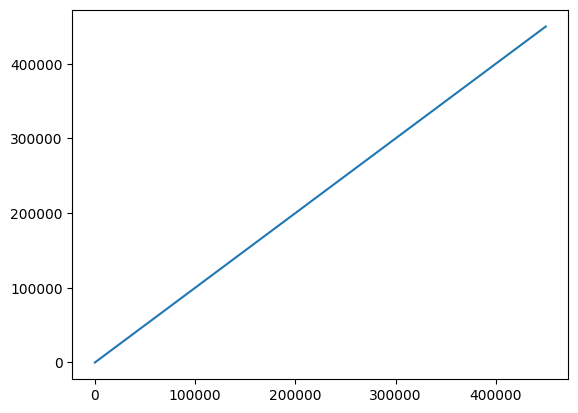

In [28]:
# plot timestamp for attach df
plt.plot(df_attack_v0.index.values)

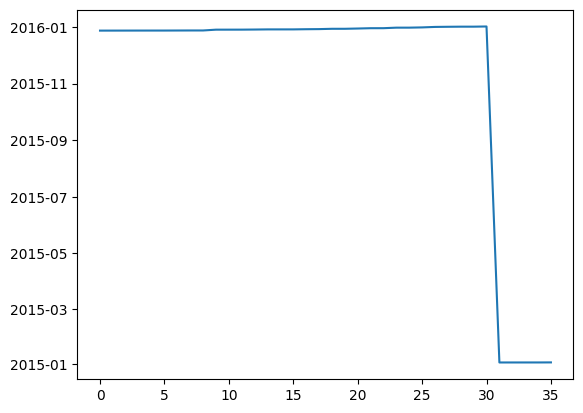

In [29]:
# plot timestamps of labels
plt.plot(df_label_time['Start Time'].values)

## Lets plot som time series

In [19]:
# clean time stamp colname
for df in [df_normal_v1, df_attack_v0]:
    df['Timestamp'] = pd.to_datetime(df[' Timestamp'])

In [20]:
# convert to pandas time series
df_normal_v1 = df_normal_v1.set_index('Timestamp', drop=True)
df_attack_v0 = df_attack_v0.set_index('Timestamp', drop=True)
df_normal_v1 = df_normal_v1.drop(' Timestamp', axis=1)
df_attack_v0 = df_attack_v0.drop(' Timestamp', axis=1)

In [21]:
# fix column names (some begin with white spaces)
df_normal_v1.columns = [s.replace(' ', '') for s in df_normal_v1.columns]
df_attack_v0.columns = [s.replace(' ', '') for s in df_attack_v0.columns]

In [26]:
# ok, lets remove everything smaller than min_date and larger than max date from the attacks and labels
df_label_time = df_label_time[(df_label_time['Start Time'] > const.SWAT_MIN_DATE) &
                         (df_label_time['Start Time'] < const.SWAT_MAX_DATE)]
df_attack_v0 = df_attack_v0[(df_attack_v0.index > const.SWAT_MIN_DATE) &
                         (df_attack_v0.index < const.SWAT_MAX_DATE)]

In [27]:
df_normal_v1.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:30:00,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2015-12-22 16:30:01,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2015-12-22 16:30:02,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2015-12-22 16:30:03,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal
2015-12-22 16:30:04,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,1,1,9.100231,0.0,3.3485,0.000256,1,1,1,Normal


In [28]:
df_label_time['Start Time'].min()

datetime.datetime(2015, 12, 28, 10, 29, 14)

In [29]:
# define plot function
def get_4_signal_plot(sensor0='AIT503', sensor1='AIT203',
                      sensor2='FIT501', sensor3='LIT401', day='all', sample_freq='60s', 
                     show_attacks=False):
    df_plot = df.copy()
    df_plot_label = df_label_time.copy()
    print(df_plot_label['Start Time'].min())
    if not day == 'all':
        df_plot = df_plot[(df_plot.index > pd.Timestamp(day)) &
                         (df_plot.index < pd.Timestamp(day)+pd.Timedelta('1d'))]
        df_plot_label = df_plot_label[(df_plot_label['Start Time'] > pd.Timestamp(day)) &
                         (df_plot_label['Start Time'] < pd.Timestamp(day)+pd.Timedelta('1d'))]
    df_plot = df_plot.resample(sample_freq).mean()

    
    sensor_selection_list=[sensor0, sensor1, sensor2, sensor3]
    num_plots = 5 if show_attacks else 4
    fig = make_subplots(rows=num_plots, cols=1, shared_xaxes=True)
    for i, s in enumerate(sensor_selection_list):
        fig.add_trace(
            go.Scatter(x=df_plot.index,
                       y=df_plot[s], name=s),
            row=i+1, col=1,
        )
    if show_attacks:
        for i in range(len(df_plot_label)):
            df_plot_label = df_plot_label.reset_index(drop=True)
            start = df_plot_label.loc[i, 'Start Time']
            end = df_plot_label.loc[i, 'End Time']
            attack = df_plot_label.loc[i, 'Attack #']
            fig.add_trace(
                go.Scatter(x=[start, end],
                           y=[1, 1], name=f'Attack #{attack}'),
                row=5, col=1,
            )

    title = f'{sensor0}, {sensor1}, {sensor2} and {sensor3}'\
            f' over time (averaged over {sample_freq})'

    fig.update_layout(height=800, width=800, title_text=title)
    fig.show()

In [42]:
# define drop down lists (see plots below)
day_list_normal = [f'2015-12-{d}' for d in range(22,28)] + ['all']
day_list_attack = [f'2015-12-{d}' for d in range(28,31)] + ['2016-01-01'] + \
                  ['2016-02-01'] + ['all']
sample_frequency_list = ['1s', '5s', '10s', '60s']
df = df_attack_v0.copy()
sensors = list(df.columns)
sensors.remove('Normal/Attack')
sensors.sort()
interact(get_4_signal_plot, sensor0=sensors, sensor1=sensors,
         sensor2=sensors, sensor3=sensors, day=day_list_attack,
         sample_freq=sample_frequency_list, show_attacks=True)

interactive(children=(Dropdown(description='sensor0', index=7, options=('AIT201', 'AIT202', 'AIT203', 'AIT401'…

<function __main__.get_4_signal_plot(sensor0='AIT503', sensor1='AIT203', sensor2='FIT501', sensor3='LIT401', day='all', sample_freq='60s', show_attacks=False)>

#### Atacknumber -> Components with symptoms
 - 1 -> [1]
 - 2 -> [1, 2]
 - 3 -> [1]
 - 4 -> Kein plan

In [44]:
df_attack_v0['P102'].value_counts()

1    392794
2      3125
Name: P102, dtype: int64

In [47]:
df_normal_v1['P102'].unique()

array([1])

In [34]:
df_normal_v1.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603', 'Normal/Attack'],
      dtype='object')

In [37]:
df_normal_v1['AIT201'].describe()

count    495000.000000
mean        263.783544
std           4.787117
min         251.666200
25%         260.734400
50%         265.284500
75%         266.982800
max         272.526300
Name: AIT201, dtype: float64

In [38]:
df_attack_v0['AIT201'].describe()

count    395919.000000
mean        215.540203
std          34.277026
min         173.737500
25%         178.736200
50%         209.561600
75%         258.010800
max         267.719800
Name: AIT201, dtype: float64

In [39]:
import matplotlib.pyplot as plt

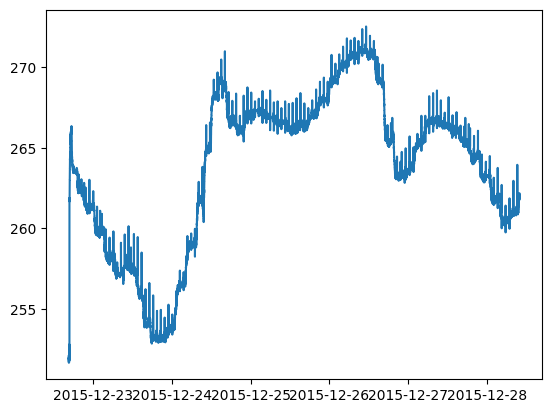

In [40]:
plt.plot(df_normal_v1['AIT201'])

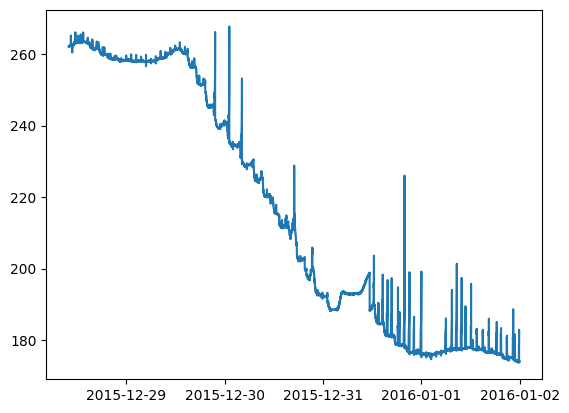

In [41]:
plt.plot(df_attack_v0['AIT201'])